## CNN on 15-scene dataset

Download the data from assignment 2.. This had a train and test directory. Each folder has 15 sub-folders corresponding to each category.

**IMPORTANT**: After you have copied the dataset, swap the names of the train and test folder, i.e., the default train folder should be test, and the other is train (the default test folder contains more images, and we want to make sure you have more images for training).

In [1]:
import numpy as np
import skimage
from skimage import io, img_as_float
from skimage.transform import resize

import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
from random import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50


import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math




### Helper functions to load images

In [2]:
categories = [
        'Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 
        'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman',
        'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise','Tom Hanks', 'Will Smith'
        ]

**TODO**: RESIZE AS PER THE REQUIREMENT OF THE SIMPLE NET BELOW (DO NOT SCALE back to 255, do not convert to uint8)

In [3]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_simple_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the 
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should also compile the model with the Adam optimiser, a cross
    entropy loss function (which one? categorical or sparse categorical?), and a single accuracy metric.
    """
    model_resnet = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    layers_to_freeze = 16

    for layer in model_resnet.layers[:layers_to_freeze]:
        layer.trainable = False

    for layer in model_resnet.layers[layers_to_freeze:]:
        layer.trainable = True

    model_tl = Sequential([
                        model_resnet,
                        Flatten(),
                        Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
                        Dropout(0.4),
                        Dense(512, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
                        Dropout(0.3),
                        Dense(17, activation='softmax', kernel_regularizer = tf.keras.regularizers.l2(0.1))
                        ])


    model_tl.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
        metrics = ['accuracy']
        )  

    return model_tl
    


#### Compile and evaluate the model

In [4]:


model = get_simple_model((224,224,3))
print(len(model.trainable_variables))
#Print the model summary 
model.summary()

14
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 17)              

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentation
DataGen = ImageDataGenerator(
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       rescale=1/255.0)

Train_data = DataGen.flow_from_directory("../../converging_models/masked_dataset/train/", target_size=(224,224), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="sparse")

Test_data = DataGen.flow_from_directory("../../converging_models/masked_dataset/test/", target_size=(224,224), 
                                         color_mode="rgb",
                                         batch_size=32, 
                                         shuffle=True,
                                         class_mode="sparse")

Found 1343 images belonging to 17 classes.
Found 337 images belonging to 17 classes.


In [6]:
steps_per_epoch =  Train_data.n // 64
validation_steps =  Test_data.n // 32

print(steps_per_epoch)
print(validation_steps)

20
10


In [7]:
# Train model using the callbacks you just created
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 3, mode = 'max', verbose = 1)

#callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
with tf.device('/device:GPU:0'):
    history = model.fit(Train_data,steps_per_epoch=steps_per_epoch, epochs=30, validation_data=Test_data, validation_steps= validation_steps,) #, callbacks=callbacks


Epoch 1/30
20/20 [==============================] - 29s 1s/step - loss: 104.8923 - accuracy: 0.0633 - val_loss: 100.7940 - val_accuracy: 0.0625
Epoch 2/30
20/20 [==============================] - 15s 766ms/step - loss: 97.2924 - accuracy: 0.0727 - val_loss: 93.4935 - val_accuracy: 0.0875
Epoch 3/30
20/20 [==============================] - 15s 762ms/step - loss: 90.2088 - accuracy: 0.0829 - val_loss: 86.6074 - val_accuracy: 0.1219
Epoch 4/30
20/20 [==============================] - 15s 760ms/step - loss: 83.4995 - accuracy: 0.1204 - val_loss: 80.1177 - val_accuracy: 0.1375
Epoch 5/30
20/20 [==============================] - 15s 750ms/step - loss: 77.2475 - accuracy: 0.1540 - val_loss: 74.1263 - val_accuracy: 0.1781
Epoch 6/30
20/20 [==============================] - 15s 750ms/step - loss: 71.4942 - accuracy: 0.1876 - val_loss: 68.5581 - val_accuracy: 0.2219
Epoch 7/30
20/20 [==============================] - 15s 754ms/step - loss: 66.1054 - accuracy: 0.2541 - val_loss: 63.4969 - val_acc

In [8]:
model.save_weights("mask_model.h5")

In [14]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

image1 = image.load_img("../../converging_models/masked_dataset/test/Sandra Bullock/Sandra_Bullock_087_cloth.jpg", target_size = (224, 224))


transformedImage = image.img_to_array(image1)
transformedImage = np.expand_dims(transformedImage, axis = 0)
transformedImage = preprocess_input(transformedImage)

prediction = model.predict(transformedImage)
print(prediction)
print(categories[np.argmax(prediction, axis=1)[0]])

1/1 [==============================] - 1s 694ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Sandra Bullock


In [9]:
#Define functions to plot accuracy and loss
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

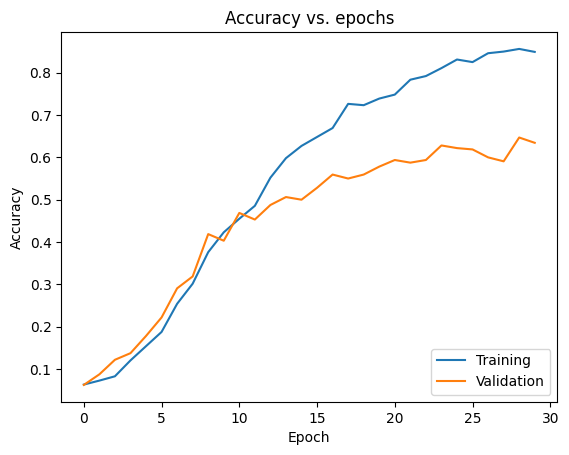

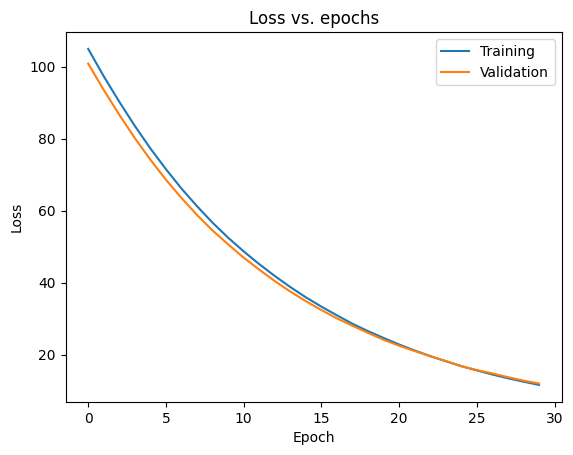

In [10]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(history)
plotLoss(history)


11/11 [==============================] - 4s 317ms/step
[[9.7252475e-03 1.2154144e-02 1.2073312e-02 ... 1.0270659e-02
  1.7258417e-02 2.4533479e-02]
 [3.3317591e-04 9.5590234e-01 5.1136882e-05 ... 2.2784448e-03
  2.8136739e-04 9.2796457e-05]
 [3.0226466e-01 2.2979726e-03 2.6444433e-02 ... 2.3193007e-02
  1.3893856e-03 1.0775312e-02]
 ...
 [4.3400521e-03 2.4129344e-02 1.3148813e-03 ... 4.3004192e-03
  3.2695245e-03 3.0937309e-03]
 [6.1627543e-05 1.2020291e-03 1.2366931e-03 ... 3.0916271e-01
  2.7787752e-04 1.5305193e-05]
 [1.0814934e-02 9.4836648e-04 7.4555044e-04 ... 6.0388347e-04
  4.3331021e-03 9.1116484e-03]]


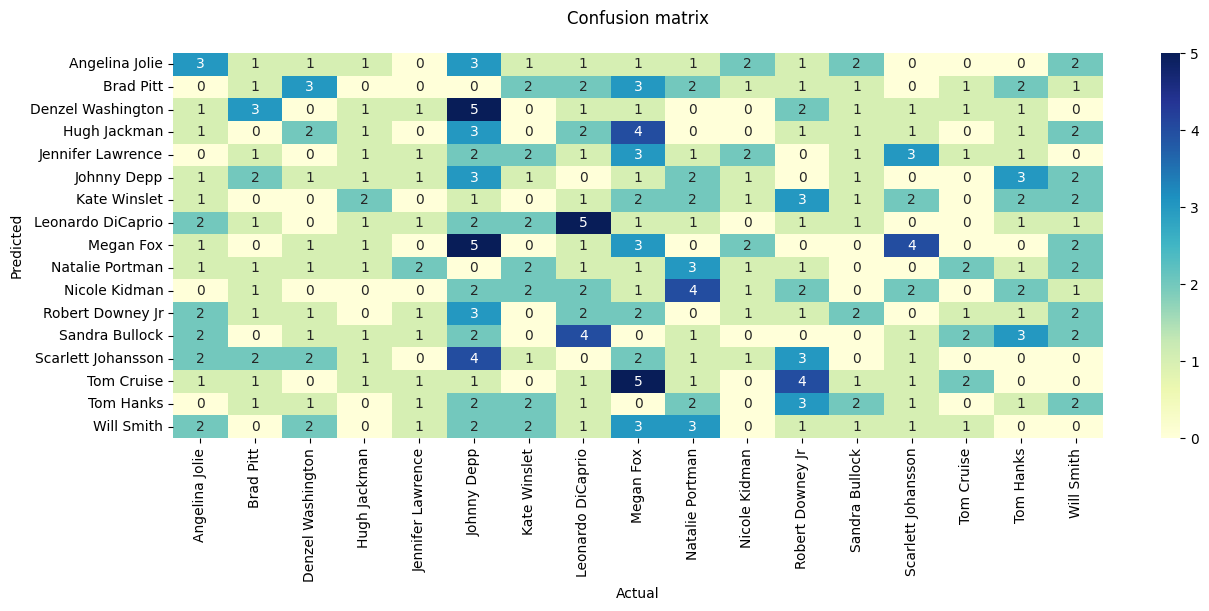

In [12]:

#Confusion Matrix 
plt.figure(figsize=(15, 5))

#Predict test images
Y_pred = model.predict(Test_data)

#Get corresponding predicted label
y_pred = np.argmax(Y_pred, axis=1)

cf = confusion_matrix(Test_data.classes, y_pred)

df_cm = pd.DataFrame(cf, index=categories, columns=categories)

sns.heatmap(df_cm, annot= True,fmt="d",cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Confusion matrix\n")
plt.show()

In [15]:
import face_recognition
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
image1 = image.load_img("./data/Validation_long/male/063822.jpg.jpg", target_size = (128, 128))

transformedImage = image.img_to_array(image1)
transformedImage = np.expand_dims(transformedImage, axis = 0)
transformedImage = preprocess_input(transformedImage)

prediction = model.predict(transformedImage)
print(categories[np.argmax(prediction, axis=1)[0]])


In [16]:
video_capture = cv2.VideoCapture(0)
#video_capture = cv2.VideoCapture("../../Dataset/Video1.mp4")




# Initialize some variables
face_locations = []
face_encodings = []
face_names = []
process_this_frame = True
predictionLabel = ''
boxColor = (0,255,0)

while True:
    ret, frame = video_capture.read()

    if process_this_frame:
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        rgb_small_frame = small_frame[:, :, ::-1]
        face_locations = face_recognition.face_locations(rgb_small_frame)

        new_frame = cv2.resize(frame, (224,224))
        x = image.img_to_array(new_frame)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x) # or version=2
        prediction = model.predict(x)
        predictionLabel = categories[np.argmax(prediction, axis=1)[0]]
        if predictionLabel == 'male':
            boxColor = (0,0,255)
        else:
            boxColor = (255,0,0)

        ###

        face_locations = face_recognition.face_locations(rgb_small_frame)

    #process_this_frame = not process_this_frame


    for (top, right, bottom, left) in face_locations:
        top *= 4
        right *= 4
        bottom *= 4
        left *= 4

        cv2.rectangle(frame, (left - 10, top - 50), (right + 10, bottom + 50), boxColor, 2)
        cv2.rectangle(frame, (left-11, bottom + 50), (right + 11, bottom + 75), boxColor, cv2.FILLED)
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, predictionLabel, (left - 6, bottom + 65), font, 0.5, (255, 255, 255), 1)

    cv2.imshow('Video', frame)

    # Hit 'q' on the keyboard to quit!
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
